In [1]:
import lbg_forecast.priors_mass_func as pr
import numpy as np
import matplotlib.pyplot as plt
import emcee
from getdist import plots, MCSamples

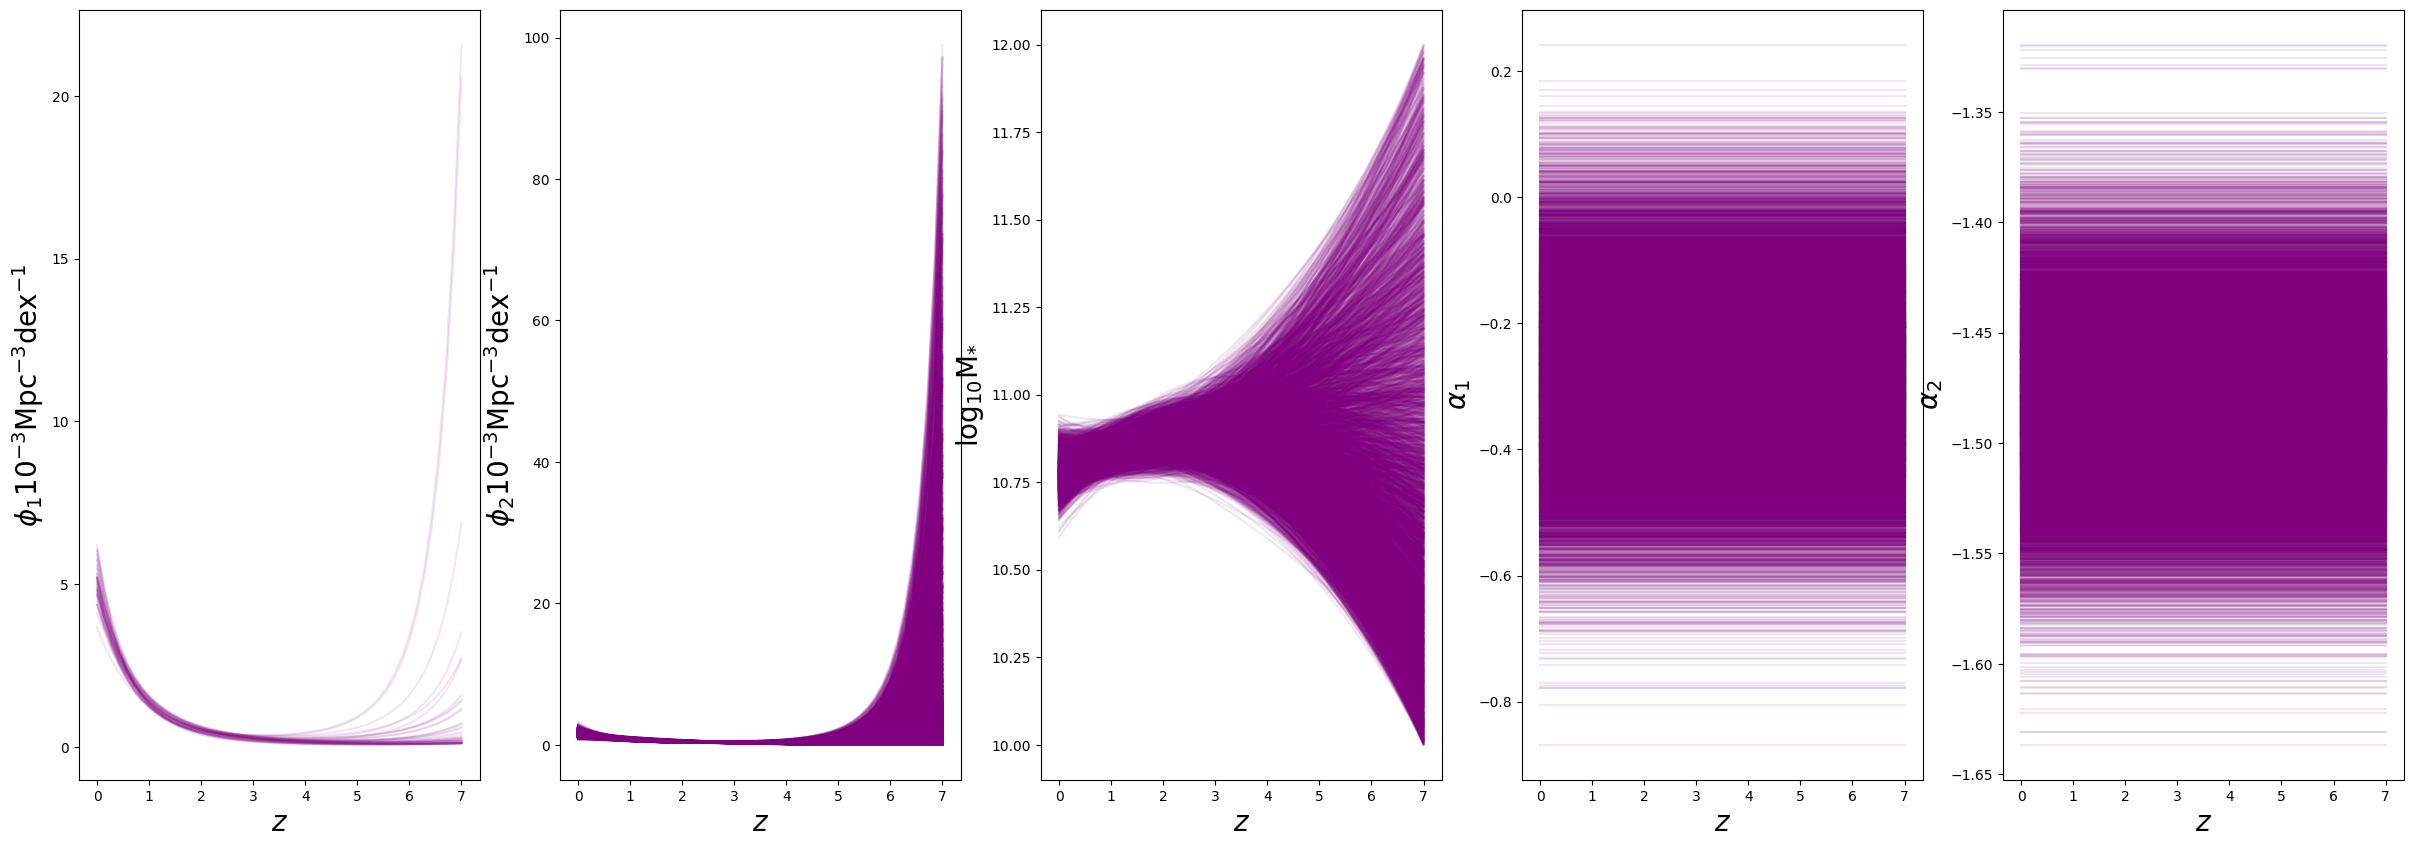

In [2]:
z_grid = np.linspace(0.0, 7.0, 50)
nsamples=10000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
selected_curves = pr.select_allowed_parameter_curves(z_grid, curves)
pr.plot_mass_function_parameter_curves(z_grid, selected_curves, log_phi_plot=False, alpha=0.1)


(1000, 50) (1000, 50) (1000, 50) (1000, 50) (1000, 50)


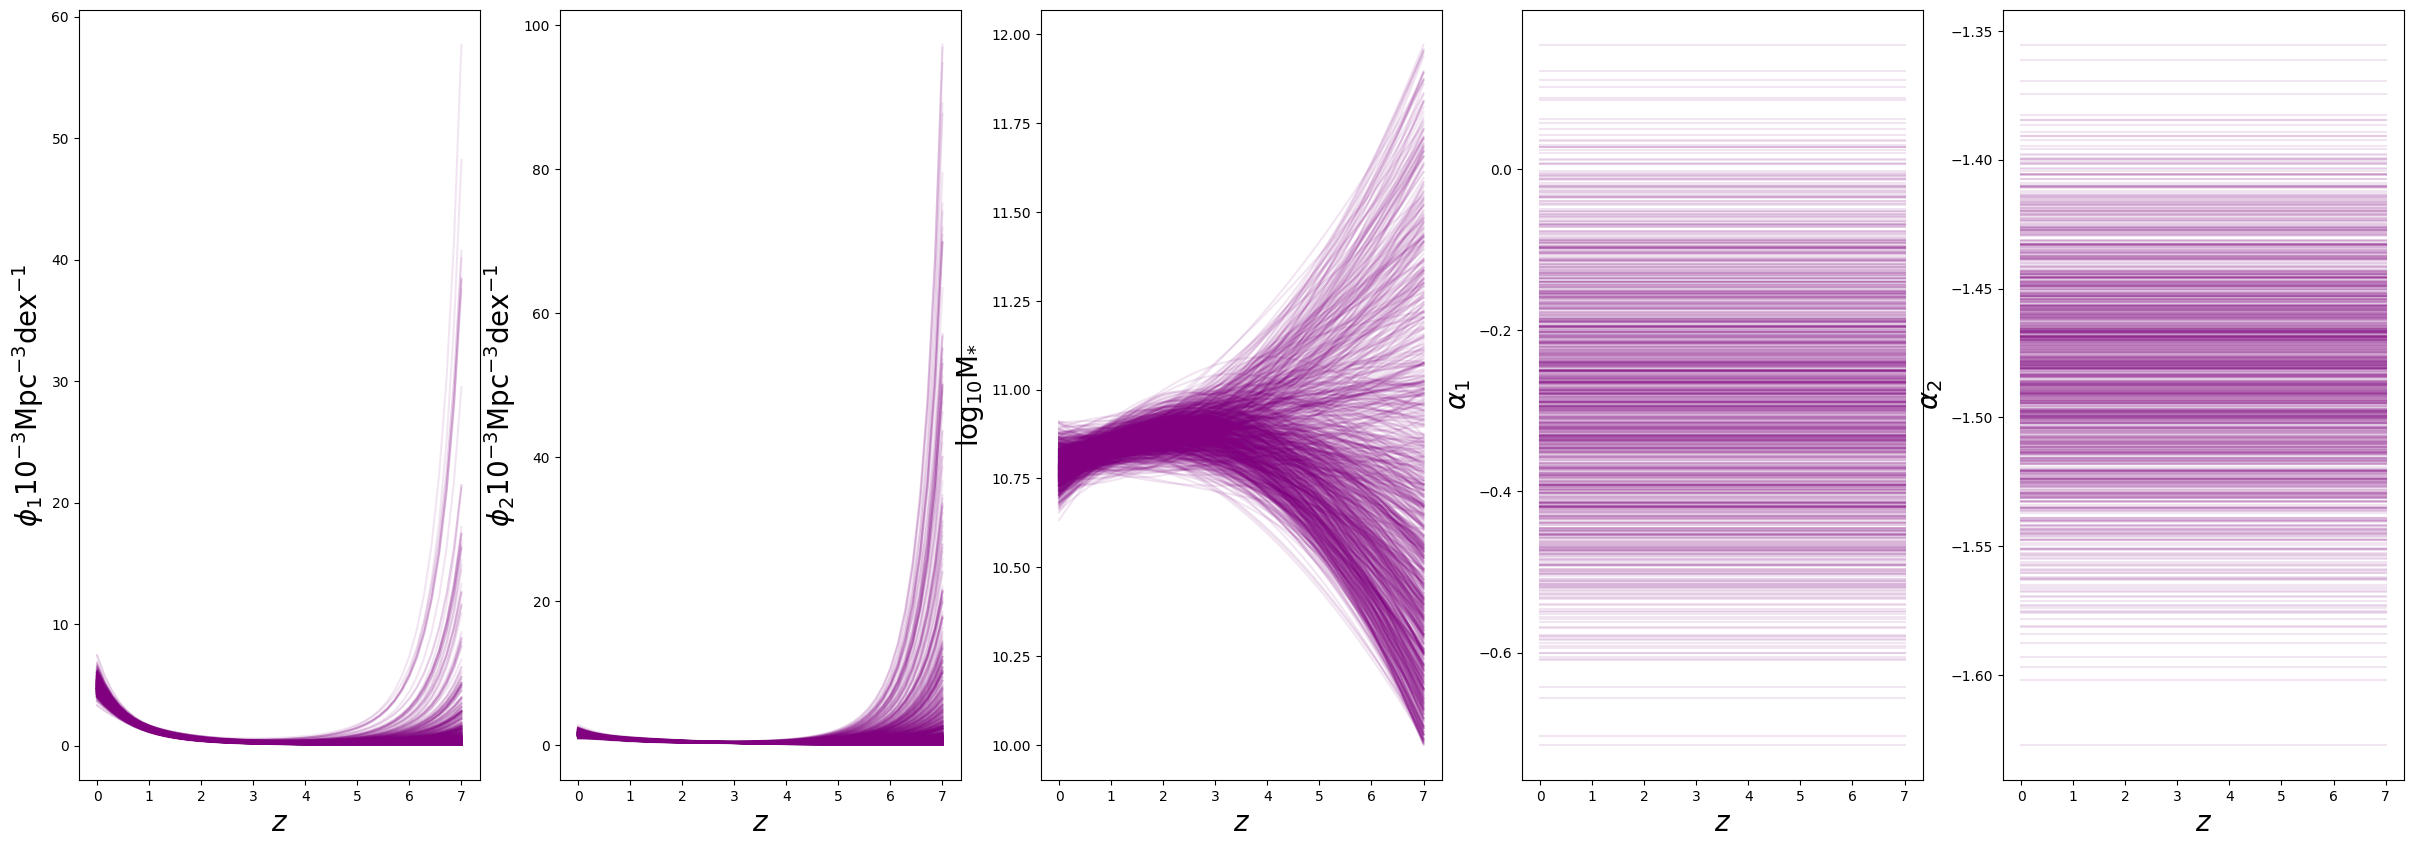

In [3]:
z_grid = np.linspace(0.0, 7.0, 50)
nsamples=1000000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
allowed_curves = pr.select_allowed_parameter_curves(z_grid, curves)

sampled_curves = pr.sample_allowed_parameter_curves(z_grid, 1000, allowed_curves)
print(sampled_curves[0].shape, sampled_curves[1].shape, sampled_curves[2].shape, sampled_curves[3].shape, sampled_curves[4].shape)
pr.plot_mass_function_parameter_curves(z_grid, sampled_curves, log_phi_plot=False, alpha=0.1)

In [4]:
prior_data = pr.preload_prior_data(zmax=7.0)

In [5]:
zsamples, logmsamples = pr.sample_redshift_mass_prior(100000, prior_data, prior_bounds=[0.0,7.0,7,13], plotting=True)

TypeError: plot_parameter_curves() missing 1 required positional argument: 'log_phi_plot'